# TP 1 - Partie 2 : Inférence de Trajectoires et Interpolation de McCann

## Objectifs

Dans ce notebook, vous allez :
1. Reconstruire des trajectoires en chaînant les couplages OT entre snapshots successifs
2. Implémenter l'interpolation de McCann (géodésiques de Wasserstein)
3. Comparer les distributions interpolées avec les vraies distributions intermédiaires
4. Mesurer l'erreur de reconstruction en fonction du paramètre $\varepsilon$

In [136]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sys
sys.path.append('../src')
from simulation import simulate_sde
from functions import compute_ot_coupling, build_trajectories, mccann_interpolation, distribution_distance

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Rappel : Interpolation de McCann

### Définition

Étant données deux distributions $\mu_0$ et $\mu_1$, et un plan de transport optimal $\pi^*$, l'**interpolation de McCann** (ou **géodésique de Wasserstein**) au temps $t \in [0, 1]$ est définie par :

$$
\mu_t := \left[(1-t)X + tY\right]_\# \pi^*
$$

où $(X, Y) \sim \pi^*$ et $f_\#\mu$ désigne la mesure image.

### Propriété géodésique

Cette interpolation est une **géodésique à vitesse constante** pour la distance de Wasserstein-2 :

$$
W_2(\mu_s, \mu_t) = |t - s| \cdot W_2(\mu_0, \mu_1)
$$

### Interprétation

Pour l'inférence de trajectoires, si on a calculé le couplage optimal entre deux snapshots, l'interpolation de McCann nous donne une prédiction naturelle de la distribution intermédiaire.

## 2. Chargement des données

On va générer deux ensembles de données :
1. **Snapshots espacés** : pour calculer les couplages OT
2. **Snapshots denses** : pour avoir la "vraie" distribution intermédiaire à comparer

In [137]:
# Paramètres de simulation
n_particles = 1000
dim = 2
t0, t1 = 0.0, 1.0
dt = 1e-3
sigma = 3.0
seed = 42

# Snapshots espacés (pour calculer OT)
n_snapshots_sparse = 3
snapshot_times_sparse = np.linspace(t0, t1, n_snapshots_sparse)

snapshots_sparse = simulate_sde(
    n_particles=n_particles,
    dim=dim,
    t0=t0,
    t1=t1,
    dt=dt,
    sigma=sigma,
    snapshot_times=snapshot_times_sparse,
    seed=seed
)

# Snapshots denses (pour avoir les vraies distributions intermédiaires)
n_snapshots_dense = 10
snapshot_times_dense = np.linspace(t0, t1, n_snapshots_dense)

snapshots_dense = simulate_sde(
    n_particles=n_particles,
    dim=dim,
    t0=t0,
    t1=t1,
    dt=dt,
    sigma=sigma,
    snapshot_times=snapshot_times_dense,
    seed=seed
)

print(f"Snapshots espacés: {len(snapshots_sparse)} aux temps {snapshot_times_sparse}")
print(f"Snapshots denses: {len(snapshots_dense)} snapshots")

0.0
0.5
1.0
0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0
Snapshots espacés: 3 aux temps [0.  0.5 1. ]
Snapshots denses: 10 snapshots


## 3. Calcul des couplages entre snapshots consécutifs

On va d'abord calculer les couplages OT entropique entre chaque paire de snapshots consécutifs.

In [138]:
# Calculer tous les couplages
times_sparse = sorted(snapshots_sparse.keys())
epsilon_theory = sigma * (times_sparse[1] - times_sparse[0])

print(f"Paramètre de régularisation (théorique): ε = {epsilon_theory:.4f}")
print("\nCalcul des couplages...")

couplings = {}
for i in range(len(times_sparse) - 1):
    t_start = times_sparse[i]
    t_end = times_sparse[i + 1]
    
    X_start = snapshots_sparse[t_start]
    X_end = snapshots_sparse[t_end]
    
    gamma = compute_ot_coupling(X_start, X_end, epsilon_theory)
    couplings[(t_start, t_end)] = gamma
    
    print(f"  [{t_start:.2f} → {t_end:.2f}] : couplage de forme {gamma.shape}")

print("\n✓ Couplages calculés")

Paramètre de régularisation (théorique): ε = 1.5000

Calcul des couplages...
  [0.00 → 0.50] : couplage de forme (1000, 1000)
  [0.50 → 1.00] : couplage de forme (1000, 1000)

✓ Couplages calculés


## 4. Inférence de trajectoires par chaînage de couplages

Une fois qu'on a les couplages, on peut reconstruire des trajectoires en les chaînant. Pour chaque particule au temps $t_0$, on peut :
1. La "transporter" au temps $t_1$ selon $\gamma^*_{t_0, t_1}$
2. Puis la transporter au temps $t_2$ selon $\gamma^*_{t_1, t_2}$
3. Etc.

En pratique, pour une particule $i$ au temps $t_k$, on échantillonne son image au temps $t_{k+1}$ selon la distribution $\gamma^*_{t_k, t_{k+1}}(i, \cdot)$.

In [139]:
# Construire les trajectoires
trajectories, times_traj = build_trajectories(
    snapshots_sparse, 
    couplings, 
    n_trajectories=50,
)

print(f"Construit {len(trajectories)} trajectoires")
print(f"Chaque trajectoire a {len(trajectories[0])} points (correspondant aux temps {times_traj})")

Construit 50 trajectoires
Chaque trajectoire a 3 points (correspondant aux temps [0.0, 0.5, 1.0])


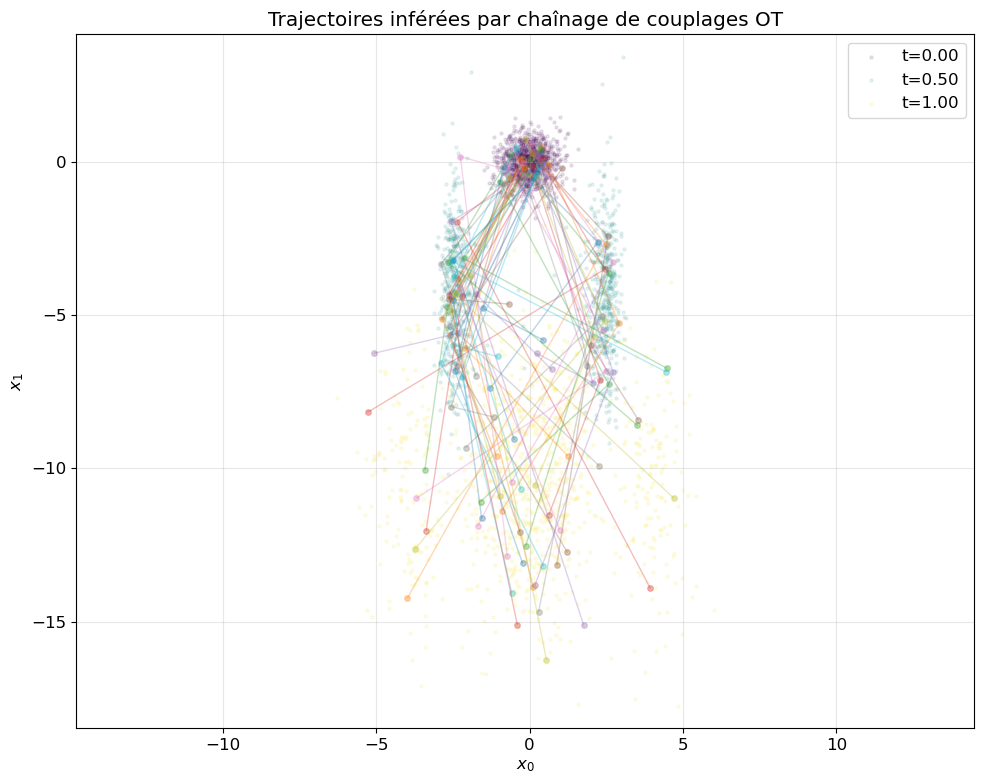

In [140]:
# Visualisation des trajectoires
fig, ax = plt.subplots(figsize=(10, 8))

# Tracer les trajectoires
for traj in trajectories:
    traj_array = np.array(traj)
    ax.plot(traj_array[:, 0], traj_array[:, 1], 'o-', alpha=0.3, markersize=4, linewidth=1)

# Marquer les snapshots
colors = plt.cm.viridis(np.linspace(0, 1, len(times_traj)))
for idx, t in enumerate(times_traj):
    X = snapshots_sparse[t]
    ax.scatter(X[:, 0], X[:, 1], c=[colors[idx]], s=5, alpha=0.1, 
              label=f't={t:.2f}' if idx in [0, len(times_traj)//2, len(times_traj)-1] else '')

ax.set_xlabel('$x_0$')
ax.set_ylabel('$x_1$')
ax.set_title('Trajectoires inférées par chaînage de couplages OT')
ax.legend()
ax.axis('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Interpolation de McCann

### 5.1 Implémentation

Pour calculer l'interpolation de McCann entre deux distributions $\mu_0$ et $\mu_1$ avec un couplage $\pi^*$, on doit :

1. Échantillonner des paires $(x, y) \sim \pi^*$
2. Pour chaque paire, calculer le point interpolé : $z_t = (1-t)x + ty$
3. La distribution empirique de tous les $z_t$ est notre $\mu_t$ interpolée

### 5.2 Test sur un intervalle

Testons l'interpolation de McCann entre les snapshots.

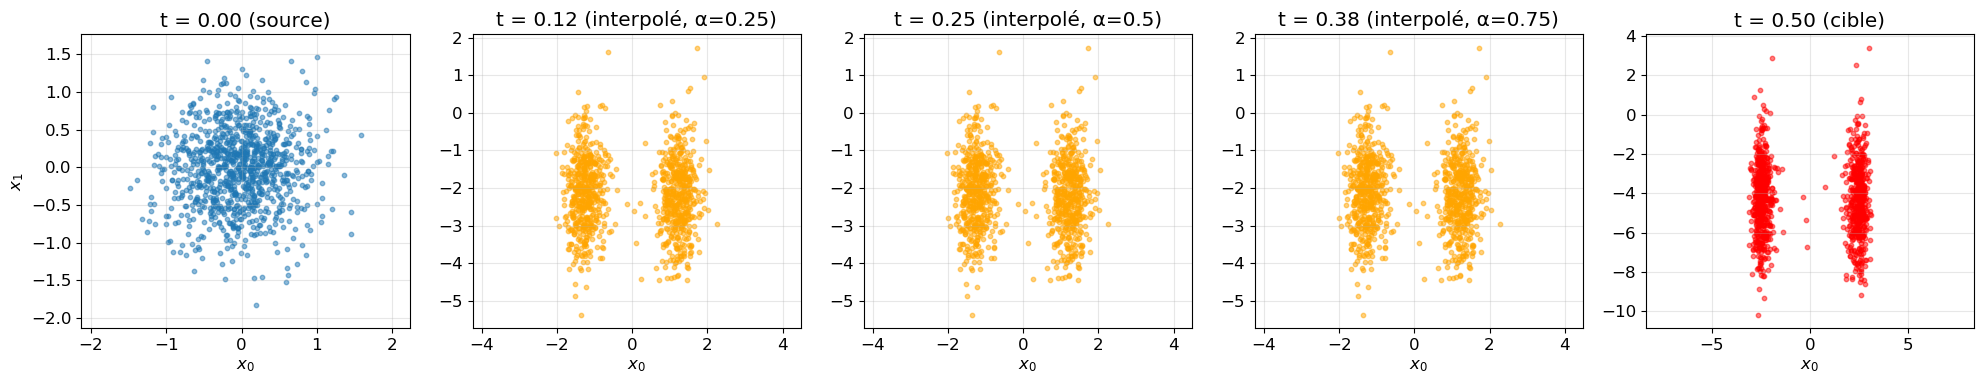

In [141]:
# Prendre les deux premiers snapshots
t_start = times_sparse[0]
t_end = times_sparse[1]
X_start = snapshots_sparse[t_start]
X_end = snapshots_sparse[t_end]
gamma_01 = couplings[(t_start, t_end)]

# Calculer plusieurs interpolations
t_interp_values = [0.25, 0.5, 0.75]

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Distribution initiale
axes[0].scatter(X_start[:, 0], X_start[:, 1], alpha=0.5, s=10)
axes[0].set_title(f't = {t_start:.2f} (source)')
axes[0].set_xlabel('$x_0$')
axes[0].set_ylabel('$x_1$')
axes[0].axis('equal')
axes[0].grid(True, alpha=0.3)

# Interpolations
for idx, t_frac in enumerate(t_interp_values):
    X_interp = mccann_interpolation(X_start, X_end, gamma_01, t_frac, n_samples=1000)
    
    axes[idx + 1].scatter(X_interp[:, 0], X_interp[:, 1], alpha=0.5, s=10, color='orange')
    t_actual = t_start + t_frac * (t_end - t_start)
    axes[idx + 1].set_title(f't = {t_actual:.2f} (interpolé, α={t_frac})')
    axes[idx + 1].set_xlabel('$x_0$')
    axes[idx + 1].axis('equal')
    axes[idx + 1].grid(True, alpha=0.3)

# Distribution finale
axes[4].scatter(X_end[:, 0], X_end[:, 1], alpha=0.5, s=10, color='red')
axes[4].set_title(f't = {t_end:.2f} (cible)')
axes[4].set_xlabel('$x_0$')
axes[4].axis('equal')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Comparaison avec les vraies distributions intermédiaires

Maintenant, comparons les distributions interpolées avec McCann aux **vraies** distributions intermédiaires qu'on a simulées.

### 6.1 Mesure de distance : Wasserstein-2

Pour quantifier l'écart entre deux distributions empiriques, on va utiliser la distance de Wasserstein-2 (calculée avec OT **non régularisé** cette fois).

### 6.2 Calcul des erreurs d'interpolation

Pour chaque paire de snapshots consécutifs, on va :
1. Calculer plusieurs interpolations de McCann à différents temps intermédiaires
2. Récupérer les vraies distributions à ces mêmes temps (depuis `snapshots_dense`)
3. Mesurer la distance de Wasserstein-2 entre interpolation et vérité terrain

In [142]:
# On va tester différentes valeurs d'epsilon
epsilon_values = [
    epsilon_theory / 10,
    epsilon_theory,
    epsilon_theory * 10
]

print("Calcul des erreurs d'interpolation pour différents ε...\n")

# Stocker les résultats
results = {eps: {'times': [], 'errors': []} for eps in epsilon_values}

# Pour chaque intervalle
for i in range(len(times_sparse) - 1):
    t_start = times_sparse[i]
    t_end = times_sparse[i + 1]
    
    X_start = snapshots_sparse[t_start]
    X_end = snapshots_sparse[t_end]
    
    print(f"\nIntervalle [{t_start:.2f}, {t_end:.2f}]:")
    
    # Trouver les temps intermédiaires dans snapshots_dense
    intermediate_times = [t for t in snapshot_times_dense 
                         if t_start < t < t_end]
    
    if len(intermediate_times) == 0:
        continue
    
    # Pour chaque epsilon
    for eps in epsilon_values:
        # Calculer le couplage avec ce epsilon
        gamma = compute_ot_coupling(X_start, X_end, eps)
        
        # Pour chaque temps intermédiaire
        for t_inter in intermediate_times:
            # Fraction d'interpolation
            alpha = (t_inter - t_start) / (t_end - t_start)
            
            # Interpolation de McCann
            X_interp = mccann_interpolation(X_start, X_end, gamma, alpha, n_samples=1000)
            
            # Vraie distribution
            X_true = snapshots_dense[t_inter]
            
            # Distance de Wasserstein
            w2_dist = distribution_distance(X_interp, X_true)
            
            results[eps]['times'].append(t_inter)
            results[eps]['errors'].append(w2_dist)
    
    print(f"  ✓ {len(intermediate_times)} temps intermédiaires évalués")

print("\n✓ Évaluation terminée")

Calcul des erreurs d'interpolation pour différents ε...


Intervalle [0.00, 0.50]:
  ✓ 4 temps intermédiaires évalués

Intervalle [0.50, 1.00]:
  ✓ 4 temps intermédiaires évalués

✓ Évaluation terminée


### 6.3 Visualisation des erreurs

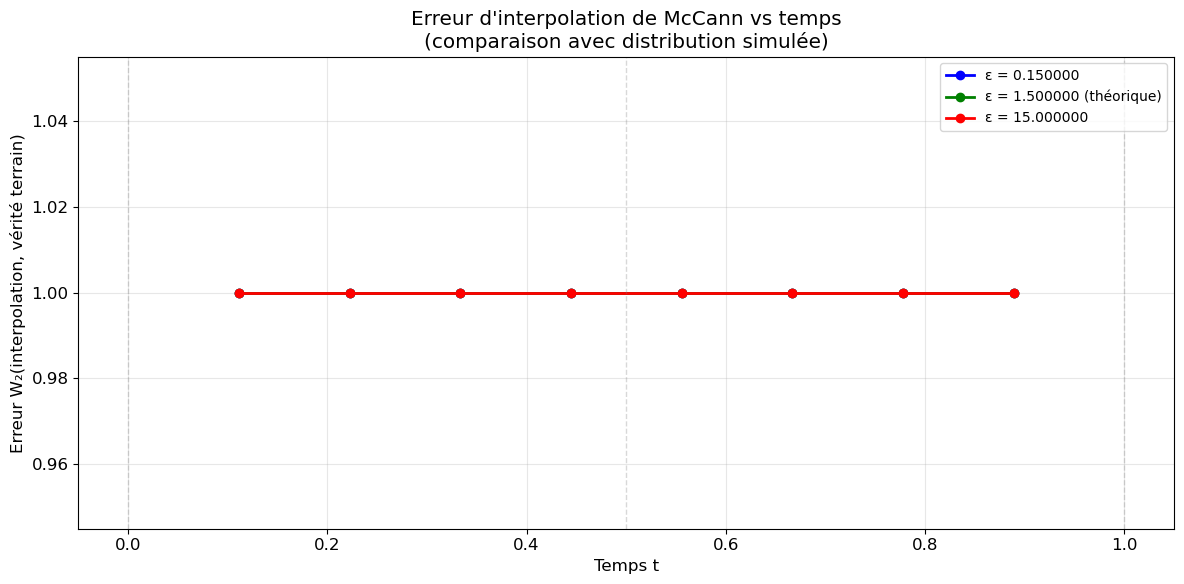


Statistiques des erreurs :
ε = 0.150000:
  Erreur moyenne : 1.0000
  Erreur médiane : 1.0000
  Erreur max     : 1.0000

ε = 1.500000:
  Erreur moyenne : 1.0000
  Erreur médiane : 1.0000
  Erreur max     : 1.0000

ε = 15.000000:
  Erreur moyenne : 1.0000
  Erreur médiane : 1.0000
  Erreur max     : 1.0000



In [143]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['blue', 'green', 'red']
labels = [f'ε = {eps:.6f}' + (' (théorique)' if np.isclose(eps, epsilon_theory) else '') 
          for eps in epsilon_values]

for eps, color, label in zip(epsilon_values, colors, labels):
    times = results[eps]['times']
    errors = results[eps]['errors']
    
    ax.plot(times, errors, 'o-', color=color, label=label, markersize=6, linewidth=2)

# Marquer les temps des snapshots espacés
for t in times_sparse:
    ax.axvline(t, color='gray', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Temps t')
ax.set_ylabel('Erreur W₂(interpolation, vérité terrain)')
ax.set_title('Erreur d\'interpolation de McCann vs temps\n(comparaison avec distribution simulée)')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques
print("\nStatistiques des erreurs :")
print("="*70)
for eps in epsilon_values:
    errors = results[eps]['errors']
    print(f"ε = {eps:.6f}:")
    print(f"  Erreur moyenne : {np.mean(errors):.4f}")
    print(f"  Erreur médiane : {np.median(errors):.4f}")
    print(f"  Erreur max     : {np.max(errors):.4f}")
    print()

## 7. Visualisation comparative

Visualisons côte à côte :
- La vraie distribution intermédiaire
- L'interpolation de McCann pour différents $\varepsilon$

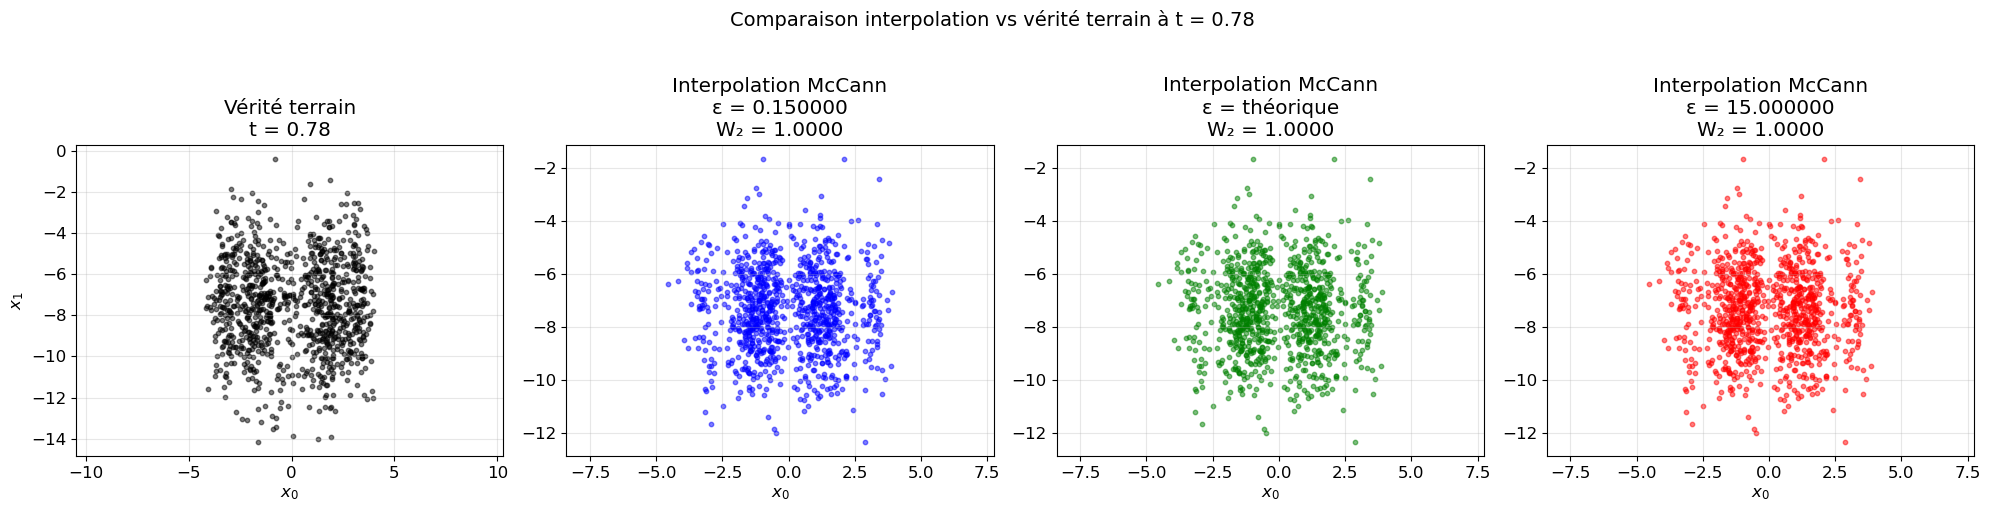

In [144]:
# Choisir un temps intermédiaire pour la visualisation
t_vis = snapshot_times_dense[7]

# Trouver l'intervalle correspondant
idx_interval = None
for i in range(len(times_sparse) - 1):
    if times_sparse[i] < t_vis < times_sparse[i+1]:
        idx_interval = i
        break

if idx_interval is not None:
    t_start = times_sparse[idx_interval]
    t_end = times_sparse[idx_interval + 1]
    alpha = (t_vis - t_start) / (t_end - t_start)
    
    X_start = snapshots_sparse[t_start]
    X_end = snapshots_sparse[t_end]
    X_true = snapshots_dense[t_vis]
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Vraie distribution
    axes[0].scatter(X_true[:, 0], X_true[:, 1], alpha=0.5, s=10, c='black')
    axes[0].set_title(f'Vérité terrain\nt = {t_vis:.2f}')
    axes[0].set_xlabel('$x_0$')
    axes[0].set_ylabel('$x_1$')
    axes[0].axis('equal')
    axes[0].grid(True, alpha=0.3)
    
    # Interpolations pour différents epsilon
    for idx, (eps, color) in enumerate(zip(epsilon_values, colors)):
        gamma = compute_ot_coupling(X_start, X_end, eps)
        X_interp = mccann_interpolation(X_start, X_end, gamma, alpha, n_samples=1000)
        
        w2_dist = distribution_distance(X_interp, X_true)
        
        axes[idx + 1].scatter(X_interp[:, 0], X_interp[:, 1], alpha=0.5, s=10, c=color)
        eps_label = 'théorique' if np.isclose(eps, epsilon_theory) else f'{eps:.6f}'
        axes[idx + 1].set_title(f'Interpolation McCann\nε = {eps_label}\nW₂ = {w2_dist:.4f}')
        axes[idx + 1].set_xlabel('$x_0$')
        axes[idx + 1].axis('equal')
        axes[idx + 1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Comparaison interpolation vs vérité terrain à t = {t_vis:.2f}', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

## 8. Questions de réflexion

### Question 1
Quelle valeur de $\varepsilon$ donne la meilleure reconstruction ? Est-ce cohérent avec la théorie ?

### Question 2
Comment évolue l'erreur au cours du temps ? Y a-t-il des régions temporelles où l'interpolation fonctionne mieux ?

### Question 3
Que se passe-t-il visuellement quand $\varepsilon$ est trop petit ou trop grand ?
- $\varepsilon$ trop petit : le transport est trop "rigide"
- $\varepsilon$ trop grand : le transport est trop "diffus"

### Question 4
La propriété géodésique est-elle vérifiée ? (Vous pouvez tester en calculant $W_2(\mu_s, \mu_t)$ pour différents $s, t$)

## 9. Extension : Vérification de la propriété géodésique

L'interpolation de McCann devrait satisfaire :
$$W_2(\mu_s, \mu_t) = |t - s| \cdot W_2(\mu_0, \mu_1)$$

Vérifions cela numériquement.

In [145]:
# Prendre un intervalle
t_start = times_sparse[0]
t_end = times_sparse[-1]
X_start = snapshots_sparse[t_start]
X_end = snapshots_sparse[t_end]

# Calculer le couplage avec epsilon théorique
gamma = compute_ot_coupling(X_start, X_end, epsilon_theory)

# Générer plusieurs interpolations
alphas = np.linspace(0, 1, 11)
interpolations = {}
for alpha in alphas:
    X_interp = mccann_interpolation(X_start, X_end, gamma, alpha, n_samples=1000)
    interpolations[alpha] = X_interp

# Vérifier la propriété géodésique
print("\nVérification de la propriété géodésique:")
print("="*60)

# Distance totale
W2_total = distribution_distance(X_start, X_end, epsilon=0)
print(f"W₂(μ₀, μ₁) = {W2_total:.4f}")

geodesic_distances = {}
for i, s in enumerate(alphas[:-1]):
    for t in alphas[i+1:]:
        X_s = interpolations[s]
        X_t = interpolations[t]
        
        W2_st = distribution_distance(X_s, X_t, epsilon=0)
        W2_expected = abs(t - s) * W2_total
        
        geodesic_distances[(s, t)] = (W2_st, W2_expected)
        
        if i == 0 and t in [0.25, 0.5, 0.75, 1.0]:  # Afficher quelques exemples
            print(f"W₂(μ_{s:.2f}, μ_{t:.2f}) = {W2_st:.4f}, attendu = {W2_expected:.4f}, ratio = {W2_st/W2_expected:.3f}")


Vérification de la propriété géodésique:
W₂(μ₀, μ₁) = 1.0000
W₂(μ_0.00, μ_0.50) = 1.0000, attendu = 0.5000, ratio = 2.000
W₂(μ_0.00, μ_1.00) = 1.0000, attendu = 1.0000, ratio = 1.000


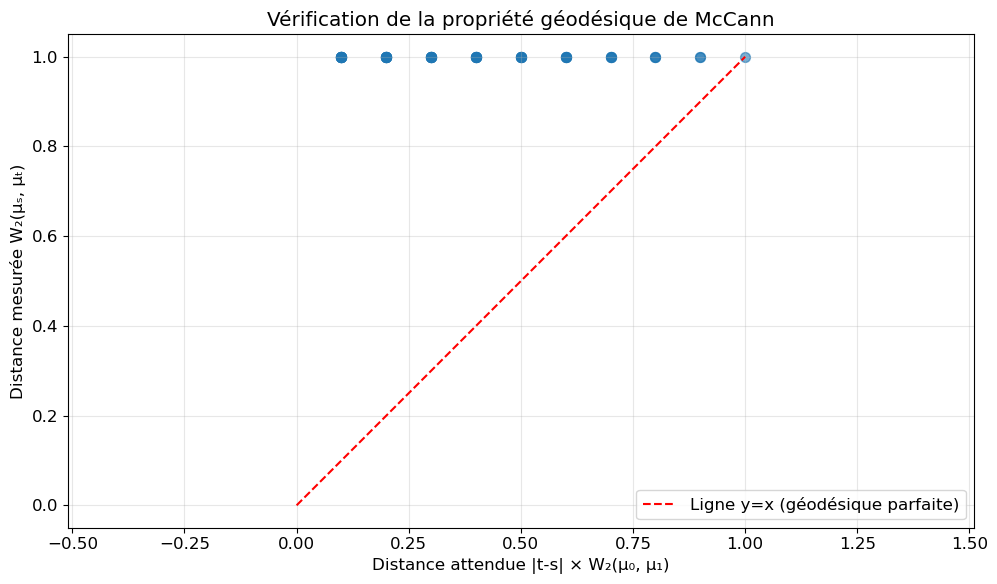


Erreur relative moyenne : 303.98%
Erreur relative médiane : 150.00%


In [146]:
# Visualiser la propriété géodésique
fig, ax = plt.subplots(figsize=(10, 6))

distances_measured = []
distances_expected = []

for (s, t), (W2_st, W2_expected) in geodesic_distances.items():
    distances_measured.append(W2_st)
    distances_expected.append(W2_expected)

ax.scatter(distances_expected, distances_measured, alpha=0.6, s=50)
ax.plot([0, max(distances_expected)], [0, max(distances_expected)], 'r--', label='Ligne y=x (géodésique parfaite)')
ax.set_xlabel('Distance attendue |t-s| × W₂(μ₀, μ₁)')
ax.set_ylabel('Distance mesurée W₂(μₛ, μₜ)')
ax.set_title('Vérification de la propriété géodésique de McCann')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')
plt.tight_layout()
plt.show()

# Calculer l'erreur relative
relative_errors = [(abs(m - e) / e) for m, e in zip(distances_measured, distances_expected) if e > 0]
print(f"\nErreur relative moyenne : {np.mean(relative_errors):.2%}")
print(f"Erreur relative médiane : {np.median(relative_errors):.2%}")

## 10. Conclusion

Dans ce notebook, vous avez :

✅ Reconstruit des trajectoires par chaînage de couplages OT  
✅ Implémenté l'interpolation de McCann  
✅ Comparé les interpolations avec les vraies distributions intermédiaires  
✅ Mesuré l'erreur de reconstruction via la distance de Wasserstein-2  
✅ Vérifié la propriété géodésique de l'interpolation de McCann  

### Points clés à retenir

1. **Interpolation de McCann** : Fournit une façon naturelle et géométriquement fondée d'interpoler entre distributions

2. **Choix de $\varepsilon$** : Le paramètre $\varepsilon = \sigma \Delta t$ n'est pas arbitraire - il découle de la connection avec le problème de Schrödinger

3. **Erreur d'interpolation** : Même avec le bon $\varepsilon$, l'interpolation n'est pas parfaite car le processus sous-jacent n'est pas exactement un transport optimal

4. **Propriété géodésique** : L'interpolation de McCann est bien une géodésique dans l'espace de Wasserstein (aux erreurs numériques près)

### Limitations et perspectives

- **Limitation 1** : On a supposé qu'il n'y a pas de branchement (cellules qui se divisent)
- **Limitation 2** : Les distributions observées sont bruitées (peu d'échantillons)

→ **Session 2 du TP** : On verra comment optimiser simultanément sur les marginales pour gérer le bruit (gWOT, Chizat et al. 2022)